In [1]:
import pcmdpy
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import seaborn.apionly as sns
from tqdm import tqdm, trange
from time import time
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days
/n/home01/bcook/.conda/envs/my_home/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [46]:
sns.set_context('poster')

In [2]:
from pcmdpy import driver, fit_model, galaxy as gal, gpu_utils, instrument as ins, isochrones as iso, utils

GPU acceleration enabled


In [3]:
gpu_utils.initialize_gpu(n=0)

using given n: 0
Starting SourceModule Code
Getting function
Past the SourceModule code
CUDAC Available


In [4]:
device = gpu_utils.pycuda.autoinit.device
device.get_attributes()

{pycuda._driver.device_attribute.MAX_THREADS_PER_BLOCK: 1024,
 pycuda._driver.device_attribute.MAX_BLOCK_DIM_X: 1024,
 pycuda._driver.device_attribute.MAX_BLOCK_DIM_Y: 1024,
 pycuda._driver.device_attribute.MAX_BLOCK_DIM_Z: 64,
 pycuda._driver.device_attribute.MAX_GRID_DIM_X: 2147483647,
 pycuda._driver.device_attribute.MAX_GRID_DIM_Y: 65535,
 pycuda._driver.device_attribute.MAX_GRID_DIM_Z: 65535,
 pycuda._driver.device_attribute.MAX_SHARED_MEMORY_PER_BLOCK: 49152,
 pycuda._driver.device_attribute.TOTAL_CONSTANT_MEMORY: 65536,
 pycuda._driver.device_attribute.WARP_SIZE: 32,
 pycuda._driver.device_attribute.MAX_PITCH: 2147483647,
 pycuda._driver.device_attribute.MAX_REGISTERS_PER_BLOCK: 65536,
 pycuda._driver.device_attribute.CLOCK_RATE: 732000,
 pycuda._driver.device_attribute.TEXTURE_ALIGNMENT: 512,
 pycuda._driver.device_attribute.GPU_OVERLAP: 1,
 pycuda._driver.device_attribute.MULTIPROCESSOR_COUNT: 14,
 pycuda._driver.device_attribute.KERNEL_EXEC_TIMEOUT: 0,
 pycuda._driver.device_

In [5]:
device.name()

'Tesla K20Xm'

In [6]:
from pycuda import cumath

In [24]:
filters = [ins.Filter.HST_F475W(1.0), ins.Filter.HST_F814W(1.0)]
iso_model = iso.Isochrone_Model(filters)
driv = driver.Driver(iso_model, gpu=True)

In [25]:
def random_model(model_class=gal.Galaxy_Model, r=-1, small=False, **kwargs):
    if r < 0:
        r = np.random
    else:
        r = np.random.RandomState(r)
    if model_class is gal.Galaxy_Model:
        if small:
            inverse = fit_model.lnprior_transform_small
        else:
            inverse = fit_model.lnprior_transform
    else:
        if small:
            inverse = fit_model.lnprior_transform_ssp_small
        else:
            inverse = fit_model.lnprior_transform_ssp
    u = r.rand(model_class._num_params)
    v = inverse(u)
    return model_class(v)

In [26]:
mags, image = driv.simulate(random_model(r=0), 256, fixed_seed=True)
pcmd_data = utils.make_pcmd(mags)
xbins = np.arange(-1.5, 4.6, 0.05)
ybins = np.arange(-12, 15.6, 0.05)
bins = np.array([xbins,ybins])
driv.initialize_data(pcmd_data, bins)

In [27]:
def log_like(im_scale, model_class=gal.Galaxy_Model, **kwargs):
    mod = random_model(model_class=model_class, **kwargs)
    mags, _= driv.simulate(mod, im_scale, **kwargs)
    pcmd = utils.make_pcmd(mags)
    return driv.loglike(pcmd)

In [30]:
log_like(128, model_class=gal.Galaxy_SSP, r=0, like_mode=0)

-60316.686748727545

In [ ]:
n_loops = 30
like_mode = 0
im_scales = [256, 512, 1024, 2048]
mean_times = []
std_times = []
model_class = gal.Galaxy_Model
for im_scale in im_scales:
    times = []
    for _ in trange(n_loops, desc=str(im_scale)):
        start = time()
        _ = log_like(im_scale, like_mode=like_mode, model_class=model_class)
        times.append(time() - start)
    mean_times.append(np.mean(times))
    std_times.append(np.std(times))

2048:  43%|████▎     | 13/30 [01:11<01:32,  5.44s/it]

In [32]:
mean_times = np.array(mean_times)
std_times = np.array(std_times)

In [36]:
mean_times_k80 = np.array([0.24963728586832681,
 0.29978235562642414,
 0.45135904153188072,
 0.97021453380584721,
 4.1823802471160887])

In [37]:
std_times_k80 = np.array([0.014632786345767316,
 0.0024156330205505395,
 0.010260011962918756,
 0.027595972553769634,
 0.088656749282534517])

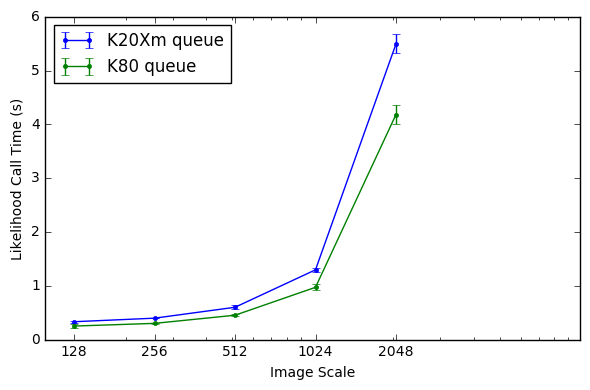

In [38]:
fig, axis = plt.subplots()
axis.errorbar(im_scales, mean_times, yerr=2*std_times, marker='.', label='K20Xm queue')
axis.errorbar(im_scales, mean_times_k80, yerr=2*std_times_k80, marker='.', label='K80 queue')
axis.set_xscale('log')#, axis.set_yscale('log')
axis.set_xlabel('Image Scale')
axis.set_ylabel('Likelihood Call Time (s)')
axis.set_xticks(im_scales)
axis.set_xticklabels(im_scales)
plt.legend(loc=0)
plt.tight_layout()

In [ ]:
n_loops = 30
like_mode = 0
im_scales = [256, 512, 1024, 2048]
mean_times_2 = []
std_times_2 = []
model_class = gal.Galaxy_SSP
for im_scale in im_scales:
    times = []
    for _ in trange(n_loops, desc=str(im_scale)):
        start = time()
        _ = log_like(im_scale, like_mode=like_mode, model_class=model_class)
        times.append(time() - start)
    mean_times_2.append(np.mean(times))
    std_times_2.append(np.std(times))

In [43]:
mean_times_2 = np.array(mean_times_2)
std_times_2 = np.array(std_times_2)
mean_times_2_k80 = np.array([0.22583422660827637,
 0.26855621337890623,
 0.40588081677754723,
 0.86273563702901201,
 3.9026559034983319])
std_times_2_k80 = np.array([0.0083412079667446147,
 0.0010617939867544029,
 0.0043278780932346798,
 0.016654544549664155,
 0.069440586912844007])

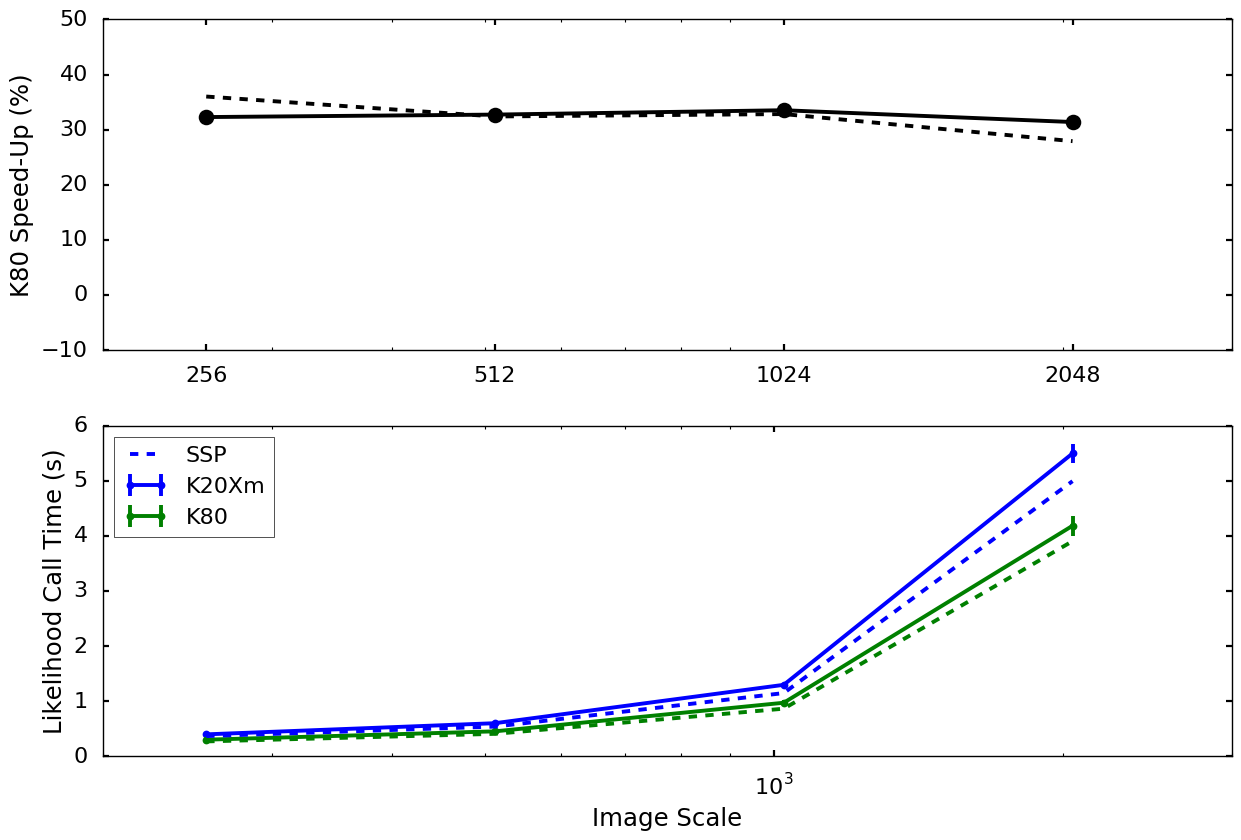

In [65]:
fig, axes = plt.subplots(nrows=2)
axis=axes[1]
axis.errorbar(im_scales[1:], mean_times[1:], yerr=2*std_times[1:], marker='.', color='b',label='K20Xm')
axis.errorbar(im_scales[1:], mean_times_k80[1:], yerr=2*std_times_k80[1:], marker='.', color='g',label='K80')
axis.plot(im_scales[1:], mean_times_2[1:], color='b',ls='--', label='SSP')
axis.plot(im_scales[1:], mean_times_2_k80[1:], color='g',ls='--')
axis.set_xlim([200, 3000])
axis.set_xscale('log')#, axis.set_yscale('log')
axis.set_xlabel('Image Scale')
axis.set_ylabel('Likelihood Call Time (s)')
plt.legend(loc=0)

ax2 = axes[0]
ax2.plot(im_scales[1:], 100.*((mean_times[1:] / mean_times_k80[1:]) - 1.), 'ko-')
ax2.plot(im_scales[1:], 100.*((mean_times_2[1:] / mean_times_2_k80[1:]) - 1.), 'k--')
ax2.set_ylim([-10., 50.])
ax2.set_ylabel('K80 Speed-Up (%)')
ax2.set_xscale('log')
ax2.set_xlim([200,3000])
ax2.set_xticks(im_scales[1:])
ax2.set_xticklabels(im_scales[1:])

plt.tight_layout()
plt.savefig('figures/k80_speed_test.pdf')

In [50]:
mean_times / mean_times_k80

array([ 1.32729166,  1.33392826,  1.32555394,  1.31759827,  1.25327065])

In [65]:
mean_times_2 / mean_times_2_k80

array([ 1.30166271,  1.29351921,  1.2510813 ,  1.28128242,  1.17380552])

In [19]:
%%timeit
log_like(2048, gpu_log=True)

1 loop, best of 3: 4.9 s per loop


In [20]:
%%timeit
log_like(2048, gpu_log=False, verbose=True)

1 loop, best of 3: 4.98 s per loop
